In [93]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import matplotlib as mpl
import rich.progress


from rich.progress import (
    BarColumn,
    DownloadColumn,
    Progress,
    TaskID,
    TextColumn,
    TimeRemainingColumn,
    TaskProgressColumn,
)

# Matrix dimension 90*90*32*6*8
NImgX_ = 90
NImgY_ = 90
NDetY_ = 32
NModule_ = 6
NDetX_ = 8

In [94]:
# Open the file.
inFname = 'sysmat_8layer_Rot_0_of_1_2mmslitin10mm_1010_idxT0_numT1in1mm_IZ0_DZ0_100.sysmat'
dataSize = NImgX_*NImgY_*NDetY_*NModule_*NDetX_

with rich.progress.open('./input/{:s}'.format(inFname), 'rb') as inF:
    # Read in the matrix
    dataUnpack = np.asarray(struct.unpack('f'*dataSize, inF.read(dataSize*4)))
    # Reshape the 5D array into a 2D matrix
    dataMatrix = dataUnpack.reshape((NDetX_ * NModule_*NDetY_, NImgX_*NImgY_))
    # inF.close()


In [95]:
imgTemplate = np.zeros((NImgX_, NImgY_))
print("{:>28}:\t{:}".format("Read-in System Matrix Shape", dataMatrix.shape))

# Remove zero rows from the matrix
sysMatrix = dataMatrix[~np.all(dataMatrix == 0, axis=1)]
print("{:>28}:\t{:}".format("Reduced System Matrix Shape", sysMatrix.shape))

 Read-in System Matrix Shape:	(1536, 8100)
 Reduced System Matrix Shape:	(864, 8100)


In [96]:
# Read in the phantom
inFname = './input/circle-phantom.npz'
dataUnpack = np.load(inFname)
dataSize = NImgX_*NImgY_
phantom = dataUnpack['arr_0'].reshape((NImgX_, NImgY_))



In [97]:
# Calculate forward projection
projection = np.matmul(sysMatrix, phantom.flatten())
print("{:>28}:\t{:}".format("Projection Shape", projection.shape))


            Projection Shape:	(864,)


In [98]:

# Implementation of Maximum-A-Priori Expectation-Maximization (MAP-EM) algorithm.

NIteration = 5000
reconImg = np.ones(NImgX_*NImgY_)
sampleRate_ = 0.1
totalSample = int(NIteration*sampleRate_)
myFrames = np.zeros((totalSample, NImgX_, NImgY_))
beta = 0.01 # weight or smoothening factor


def backwardProj(reconImg, projection, sysMatrix):
    forwardLast = np.matmul(sysMatrix, reconImg)
    quotients = projection/forwardLast
    numerator = np.matmul(quotients, sysMatrix)
    denominator = np.sum(sysMatrix, axis=0)


    n, m = NImgX_, NImgY_
    reconImg = reconImg.reshape((NImgX_, NImgY_))
    potential_function_derivative = np.zeros_like(reconImg, dtype=np.float32)
    
    for i in range(1, n-1):
        for j in range(1, m-1):
            
            # finding the median of a 3x3 submatrix centered at (i,j)
            _3x3_mask = reconImg[i-1:i+2, j-1:j+2]
            median = np.median(_3x3_mask)
            
            # calculate the potential function's derivative using median method
            if median != 0:
                potential_function_derivative[i][j] = beta * (reconImg[i][j] - median)/median


    reconImg = reconImg.flatten()
    denominator = denominator + potential_function_derivative.flatten()
    
    return numerator/denominator * reconImg



progress = Progress(
    TextColumn("[progress.description]{task.description}"),
    BarColumn(),
    # TaskProgressColumn(),
    "{task.completed}/{task.total}",
    TimeRemainingColumn(),
)


# Back Propogation iterations
img_frames = []
with progress:
    progress.console.print("Iterative reconstruction calculation...")
    task1 = progress.add_task("Iteration:", total=NIteration)
    
    for iter in range(NIteration):
        reconImg = backwardProj(reconImg, projection, sysMatrix)

        # storing it in a 2d matrix form
        img_frames.append(reconImg.reshape((NImgX_, NImgY_)))

        progress.advance(task1)
        if iter % 500 == 0:
            print(iter, "Iteration done")



Iterative reconstruction calculation...

0 done

100 done

200 done

300 done

400 done

500 done

600 done

700 done

800 done

900 done

1000 done

1100 done

1200 done

1300 done

1400 done

1500 done

1600 done

1700 done

1800 done

1900 done

2000 done

2100 done

2200 done

2300 done

2400 done

2500 done

2600 done

2700 done

2800 done

2900 done

3000 done

3100 done

3200 done

3300 done

3400 done

3500 done

3600 done

3700 done

3800 done

3900 done

4000 done

4100 done

4200 done

4300 done

4400 done

4500 done

4600 done

4700 done

4800 done

4900 done

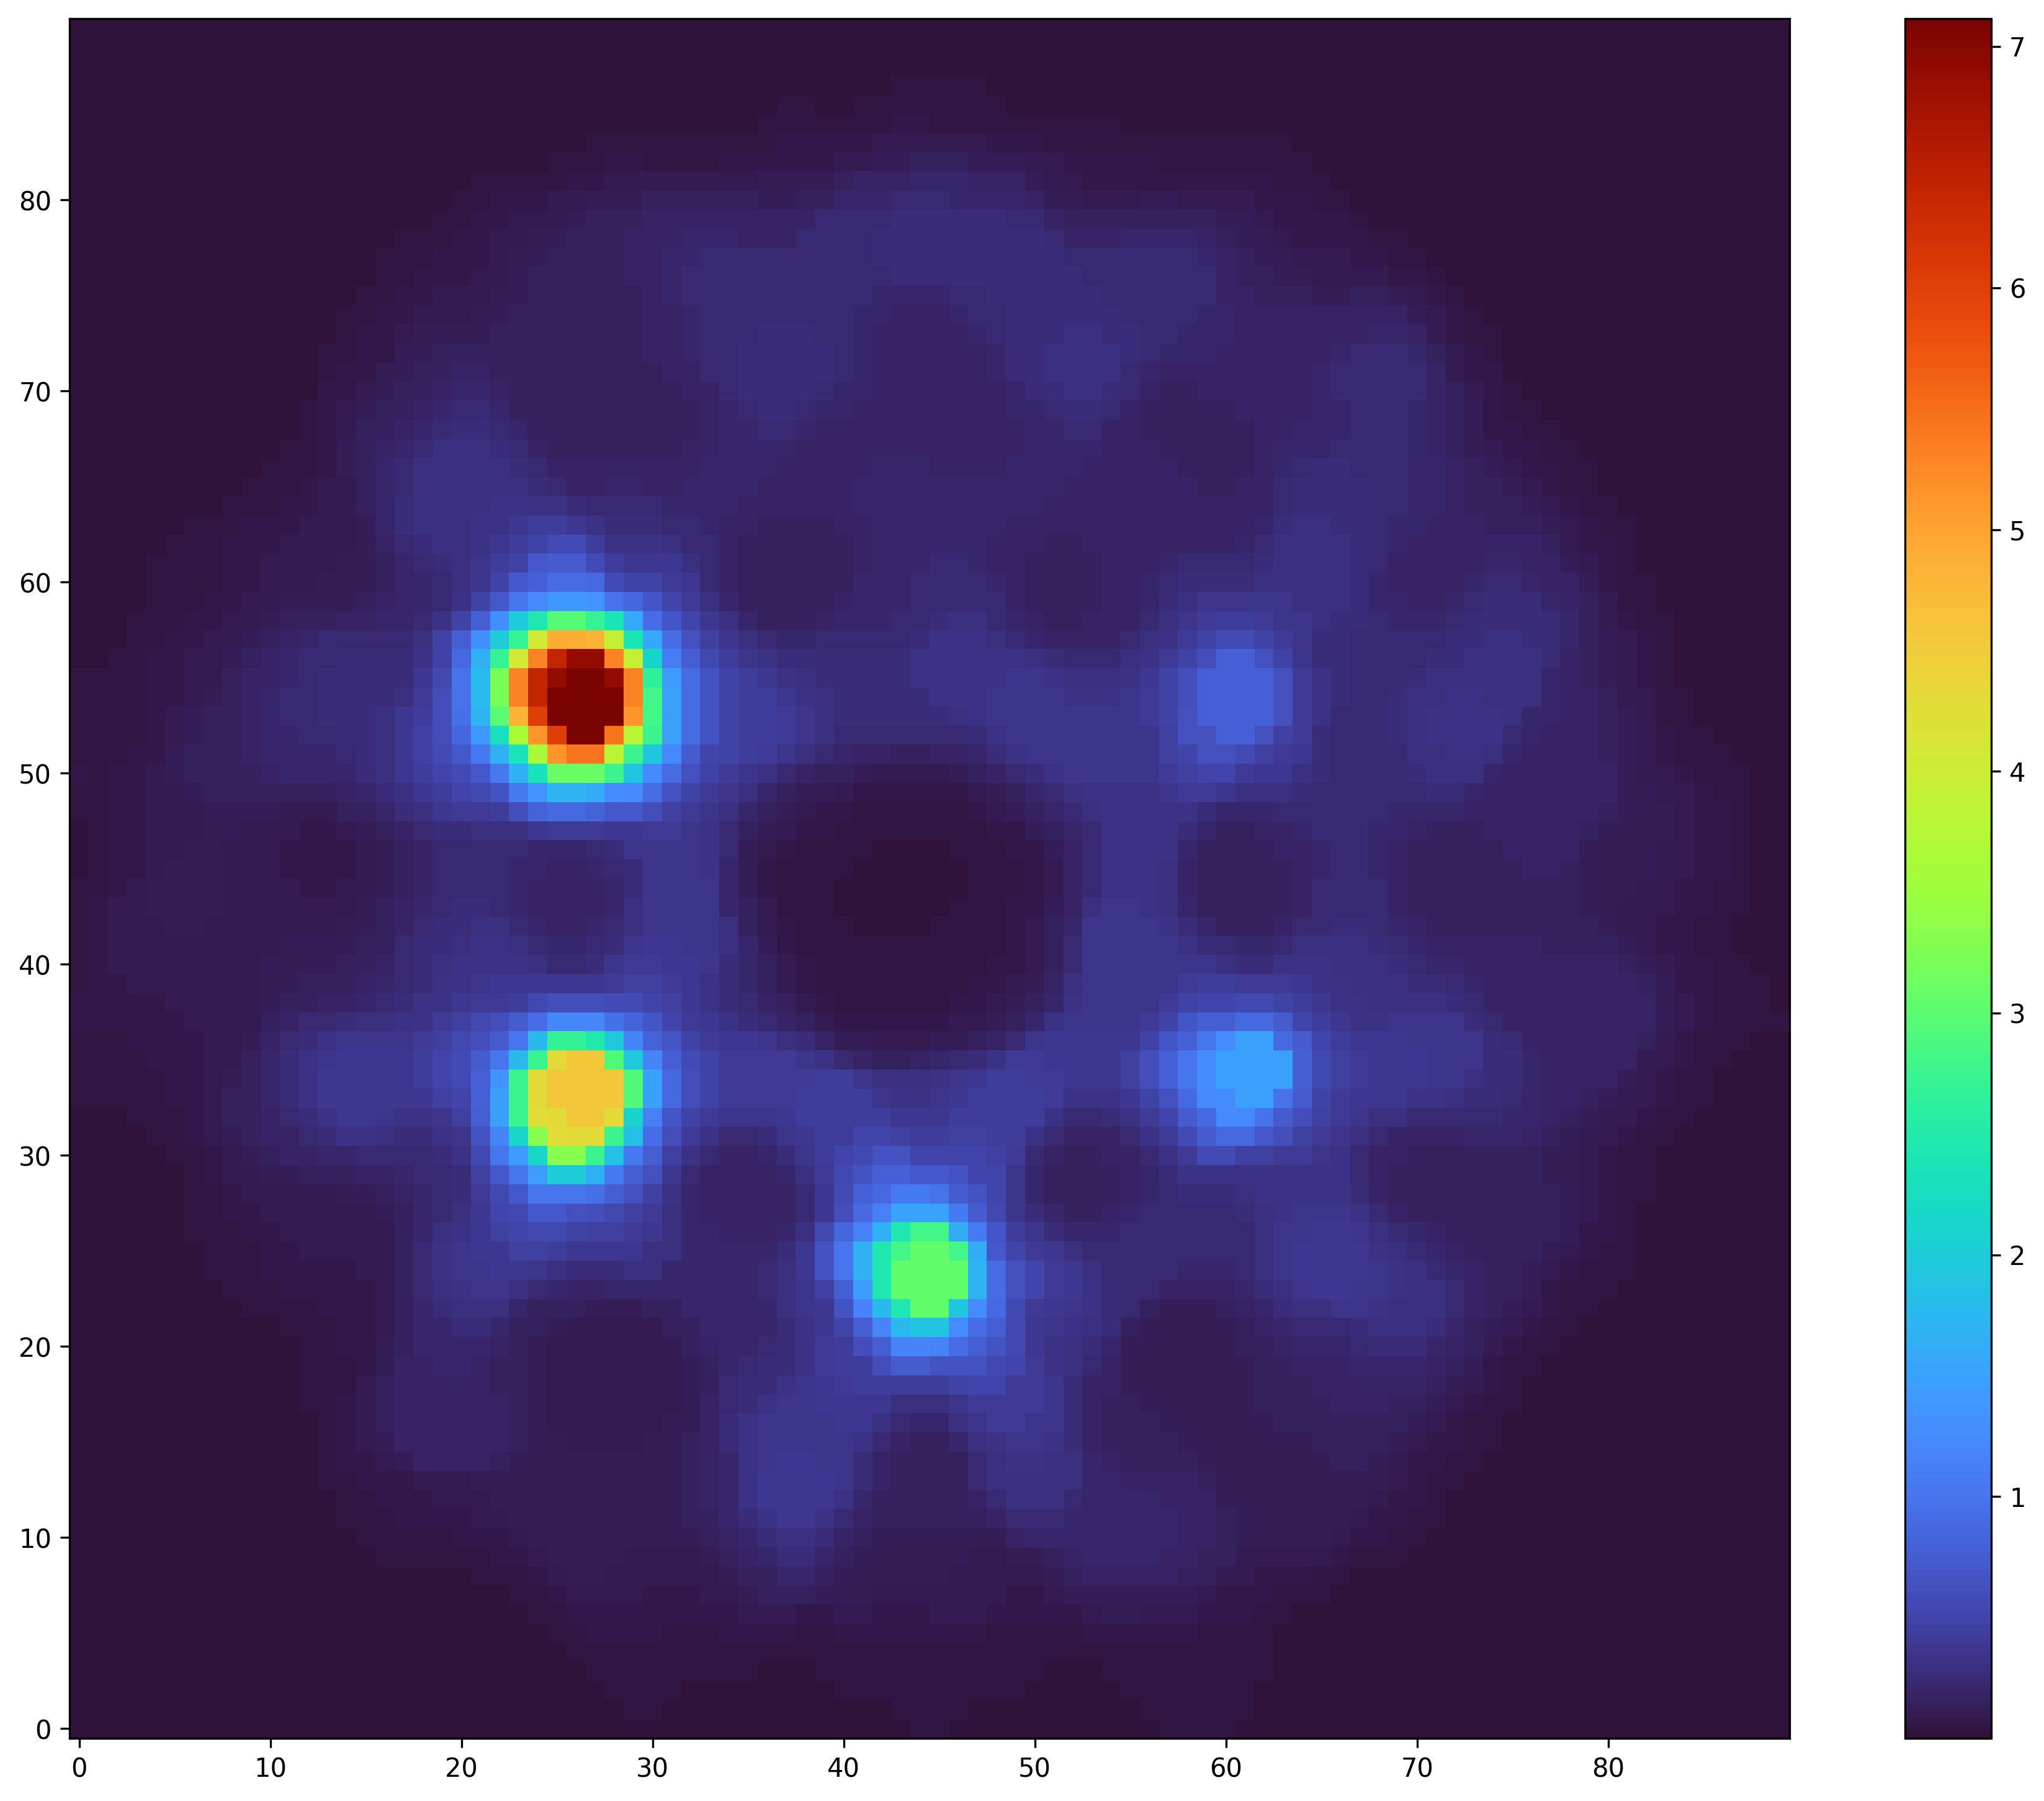

In [100]:
# Plot the image of the last iteration (last entry in myFram)

plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["figure.dpi"] = 300
fig, ax = plt.subplots()
imshow_obj=ax.imshow(myFrames[-1], cmap=mpl.colormaps['turbo'],origin='lower')
fig.colorbar(imshow_obj, ax=ax)